# Distributed Memory
> Random Features enable Dense Associative Memory to store patterns in a distributed manner across a large number of neurons.

:::{.callout-warning}
## Under Construction
:::

In this notebook, we demonstrate how we utilize random features to disentangle the size of the Dense Associative Memory network from the number of memories to be stored. Given the standard log-sum-exp energy $E_\beta(\cdot; \boldsymbol{\Xi})$, corresponding to a model $f_\boldsymbol{\Xi}$ of size $O(DK)$, we demonstrate how we can use the trigonometric random features to develop an approximate energy $\tilde{E}_\beta(\cdot; \mathbf{T})$ using a distributed representation $\mathbf{T}$ of the memories $\boldsymbol{\Xi} = \{ \boldsymbol{\xi}^\mu, \mu \in [\![ K ]\!] \}$, thus giving us a model $f_{\mathbf{T}}$ of size $O(Y)$.

For further details on this work, please see the following publication:
> Hoover, B., Chau, D.H., Strobelt, H., Ram, P. and Krotov, D., 2023. **Dense Associative Memory Through the Lens of Random Features**. In The Thirty-eighth Annual Conference on Neural Information Processing Systems. [[paper]](https://proceedings.neurips.cc/paper_files/paper/2024/file/29ff36c8fbed10819b2e50267862a52a-Paper-Conference.pdf) [[GitHub]](https://github.com/bhoov/distributed_DAM)

In [1]:
#| hide
import jax
import jax.numpy as jnp
from jaxtyping import (
    Float, Array, PyTree, jaxtyped, UInt, Bool
)
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from typing import *
from tqdm import tqdm, trange

In [2]:
rng = jr.PRNGKey(779)
ngenerators = 10
rnglist = jr.split(rng, ngenerators)

## Exact Energy Function

Consider a set of memories $\boldsymbol{\Xi} = \{ \boldsymbol{\xi}^1, \ldots, \boldsymbol{\xi}^K \}$ where each memory $\boldsymbol{\xi}^\mu \in \mathbb{R}^D$ is a vector in a $D$-dimensional Euclidean space. For a state vector $\mathbf{v} \in \mathbb{R}^D$, the commonly used _log-sum-exp_ energy is given by
$$
E_\beta( \mathbf{v}; \boldsymbol{\Xi} ) = - \frac{1}{\beta} \log \sum_{\mu = 1}^K \exp \left(- \frac{\beta}{2} \left\Vert \mathbf{v} - \boldsymbol{\xi}^\mu \right \Vert^2 \right),
$$
where $\beta > 0$ is the _inverse-temperature_ controlling the sharpness of the energy near the memories, with larger values of $\beta$ implying sharper energy landscapes, while smaller values induce smoother ones.

We can implement this energy function as follows

In [3]:
def lse_energy(
    state: Float[Array, "D"],
    memories: Float[Array, "K D"],
    beta: float
) -> Float[Array, ""]:
    """Compute the standard log-sum-exp energy"""
    """using the negative square Euclidean distance"""
    return -(1 / beta) * jax.nn.logsumexp(
        -beta / 2 * ((state - memories) ** 2).sum(-1), axis=0
    )


### Visualizing the Energy in 2D

In [4]:
maxabs = 5
xmin, xmax = ymin, ymax = -maxabs, maxabs
nsteps = 50
gpts = jnp.linspace(xmin, xmax, nsteps)
V = jnp.array(jnp.meshgrid(gpts, gpts))

# Randomly generating memories in the selected domain
rngidx = 0
D = 2
K = 8
Xi = jr.uniform(
    rnglist[rngidx], (K, D)
) * 2 * maxabs - maxabs

In [5]:
HMA = 0.8
CMAP = 'coolwarm'

In [6]:
def plot_energy_landscape(
    energies,
    plt_ax,
    bounds,
    colormap='coolwarm',
    heatmap_alpha=0.8
):
    plt_ax.imshow(
        energies, extent=bounds,
        origin='lower', cmap=colormap,
        alpha=heatmap_alpha,
    )
    plt_ax.tick_params(
        axis='both', which='both', 
        top=False, bottom=False, 
        labelbottom=False, labelleft=False, 
        left=False, right=False
    )

In [7]:
def plot_memories(
    memories,
    plt_ax,
    marker='*',
    color='black'
):
    plt_ax.scatter(
        memories[:, 0], memories[:, 1],
        marker=marker, color=color,
    )

In [8]:
def plot_energy_descent(
    energies,
    plt_ax,
    color='xkcd:slate'
):
    plt_ax.plot(np.arange(energies.shape[0]), energies, color=color)
    plt_ax.set_xlabel(r"$T$")
    plt_ax.set_ylabel('Energy') 

100%|███████████████| 5/5 [00:05<00:00,  1.06s/it]


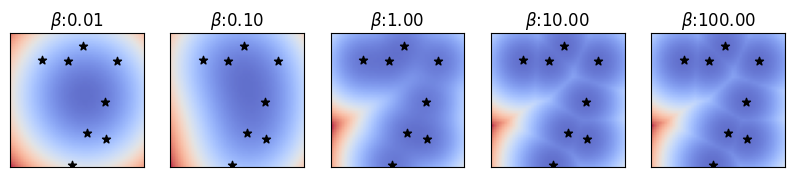

In [9]:
betas = [0.01, 0.1, 1, 10, 100]
figscaler = 2
fig, axs = plt.subplots(
    1, len(betas), figsize=(
        len(betas) * figscaler, 
        figscaler
    ),
    sharex=True, sharey=True
)
beta_en_map = {}
for b, ax in tqdm(
    zip(betas, axs), total=len(betas),
    colour='green', ncols=50
):
    en = np.zeros_like(V[0])
    for i in range(nsteps):
        for j in range(nsteps):
            en[i,j] = lse_energy(V[:, i, j], Xi, b)
    beta_en_map[b] = en
    plot_energy_landscape(
        en, ax, np.array([xmin, xmax, ymin, ymax])
    )
    plot_memories(Xi, ax)
    ax.set_title(r"$\beta$" + f":{b:0.2f}")
plt.show()

### Minimizing the Energy via Gradient Descent 

For an initial state vector $\mathbf{q} \in \mathbb{R}^D$, we can minimize its energy utilizing the energy gradient. Initializing the energy descent at the $\mathbf{q}$, that is $\mathbf{v}^{(0)} \gets \mathbf{q}$, we perform the following gradient descent steps for $T$ iterations:
$$
\mathbf{v}^{(t)} \gets \mathbf{v}^{(t-1)} - \alpha \nabla_{\mathbf{v}} E_\beta( \mathbf{v}^{(t-1)}; \boldsymbol{\Xi} ), 
$$
for $t = 1, \ldots, T$ with $\alpha > 0$ as the step-size (or learning rate) for the energy descent. The final $\mathbf{v}^{(T)}$ is the output of the model.

We can implement this using auto-differentiation in JAX by computing the gradient of the `lse_energy` function with respect to its input `state`.

In [10]:
def lse_energy_descent( 
    q: Float[Array, "D"],
    memories: Float[Array, "K D"],
    beta,
    energy_fn,
    depth: int=10,
    alpha: float = 0.01,
    return_grads=False,
    clamp_idxs: Optional[Bool[Array, "D"]]=None
) -> Float[Array, "D"]: 
    """Energy descent with the LSE energy"""
    # en = lambda state: energy_fn(state, memories, beta) 
    dEdxf = jax.jit(jax.value_and_grad(energy_fn))
    logs = {}
    def step(x, i):
        E, dEdx = dEdxf(x, memories, beta)
        if clamp_idxs is not None:
            dEdx = jnp.where(clamp_idxs, 0, dEdx)
        x = x - alpha * dEdx
        aux = (E, dEdx) if return_grads else (E,)
        return x, aux
    x, aux = jax.lax.scan(step, q, jnp.arange(depth))
    logs['energies'] = aux[0]
    if return_grads:
        logs['grads'] = aux[1]
    return x, logs

#### Energy Descent with the LSE Energy

As an example, we will use the previous set of memories to perform the energy descent for a randomly generated query $\mathbf{q} \in \mathbb{R}^D$ using the above function `lse_energy_descent`. We will note the intermediate states $\mathbf{v}^{(0)}, \ldots, \mathbf{v}^{(T)}$, and the energy $E_\beta(\mathbf{v}^{(t)}; \boldsymbol{\Xi}), t \in [\![ T ]\!]$ at each layer of the DenseAM (equivalently, the energy at each iteration of the energy gradient descent).

In the following example, the number of DenseAM layers (equivalently, the number of energy descent steps) is set at $T = 1000$, and we use a step-size $\alpha = 0.01$. We will plot the intermediate states at every `NUPDATES=25` layers.

100%|███████████████| 5/5 [00:19<00:00,  3.90s/it]


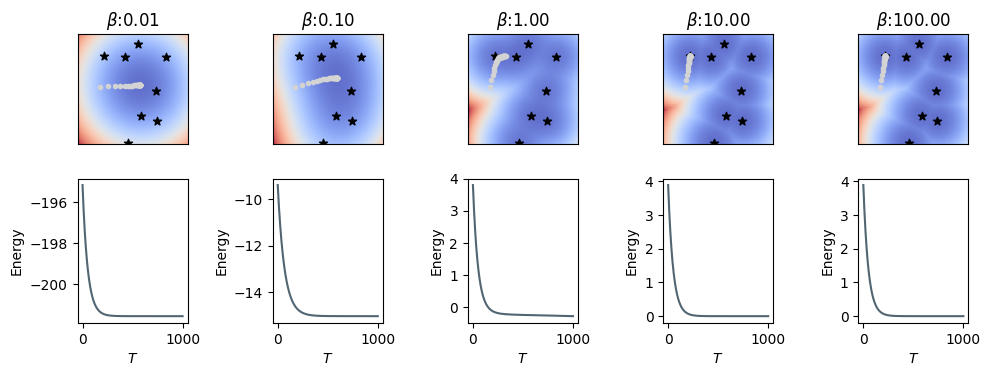

In [11]:
NSTATES = 40
NUPDATES = 25
ALPHA = 0.01
rngidx = 7
fig, axs = plt.subplots(
    2, len(betas), figsize=(
        len(betas) * figscaler, 
        2 * figscaler
    ),
    sharex="row",
)
for bidx, b in tqdm(
    enumerate(betas), total=len(betas),
    colour='green', ncols=50
):
    # Randomly generating a query
    query = jr.uniform(
        rnglist[rngidx], (D, )
    ) * 2 * maxabs - maxabs
    qstates = [query]
    qens = []
    # Perform energy descent
    for i in range(NSTATES):
        query, logs = lse_energy_descent(
            query, Xi, b, lse_energy,
            depth=NUPDATES, alpha=ALPHA
        )
        qstates += [query]
        qens += [logs['energies']]
    plot_energy_landscape(
        beta_en_map[b], axs[0, bidx], np.array([xmin, xmax, ymin, ymax])
    )
    plot_memories(Xi, axs[0, bidx])
    axs[0, bidx].set_title(r"$\beta$" + f":{b:0.2f}")
    qstates = np.array(qstates)
    plot_memories(qstates, axs[0, bidx], marker='.', color='lightgrey')
    qens = np.array(qens).reshape(-1)
    plot_energy_descent(qens, axs[1, bidx])
    # break
fig.tight_layout()
plt.show()

## Viewing Energy as a Kernel Sum

$$
E_\beta( \mathbf{v}; \boldsymbol{\Xi} ) 
= - \frac{1}{\beta} \log \sum_{\mu = 1}^K \underbrace{
  \exp \left(- \frac{\beta}{2} \left\Vert \mathbf{v} - \boldsymbol{\xi}^\mu \right \Vert^2 \right)
}_{\kappa(\sqrt{\beta}\mathbf{v}, \sqrt{\beta}\boldsymbol{\xi}^\mu)}
= - \frac{1}{\beta} \log \sum_{\mu = 1}^K \kappa \left(\sqrt{\beta}\mathbf{v}, \sqrt{\beta}\boldsymbol{\xi}^\mu \right),
$$

### Simplifying the Kernel Sum with Random Features

$$
\kappa(\mathbf{x}, \mathbf{x}') = \left\langle \phi(\mathbf{x}), \phi(\mathbf{x}') \right\rangle
$$

### Examples of Random Features

$$
\Phi(\mathbf{x}) = \frac{1}{\sqrt{Y}} \left[ \begin{array}{c}
  \cos \langle \boldsymbol{\omega}^1, \mathbf{x} \rangle \\
  \sin \langle \boldsymbol{\omega}^1, \mathbf{x} \rangle \\
  \cos \langle \boldsymbol{\omega}^2, \mathbf{x} \rangle \\
  \sin \langle \boldsymbol{\omega}^2, \mathbf{x} \rangle \\
  \cdots \\
  \cos \langle \boldsymbol{\omega}^Y, \mathbf{x} \rangle \\
  \sin \langle \boldsymbol{\omega}^Y, \mathbf{x} \rangle \\
\end{array}\right], 
\qquad 
\Phi(\mathbf{x}) = \frac{1}{\sqrt{Y}} \left[ \begin{array}{c}
  \exp (+\langle \boldsymbol{\omega}^1, \mathbf{x} \rangle) \\
  \exp (-\langle \boldsymbol{\omega}^1, \mathbf{x} \rangle) \\
  \exp (+\langle \boldsymbol{\omega}^2, \mathbf{x} \rangle) \\
  \exp (-\langle \boldsymbol{\omega}^2, \mathbf{x} \rangle) \\
  \cdots \\
  \exp (+\langle \boldsymbol{\omega}^Y, \mathbf{x} \rangle) \\
  \exp (-\langle \boldsymbol{\omega}^Y, \mathbf{x} \rangle) \\
\end{array}\right], 
\quad
\boldsymbol{\omega}^i \sim \mathcal{N}(0, \mathbf{I}_D), i \in [\![ Y ]\!].
$$

In [12]:
def sin_cos_phi(
    x: Float[Array, "... D"],
    RF:Float[Array, "Y D"],
    beta: float
) -> Float[Array, "... 2Y"]:
    """A random features using trigonometric function"""
    Y = RF.shape[0]
    h = jnp.sqrt(beta) * (x @ RF.T)
    return 1 / jnp.sqrt(Y) * jnp.concatenate(
        [ jnp.cos(h), jnp.sin(h)], axis=-1
    )

### Approximating the Energy with Random Features

#### Approximate Energy Descent

In [13]:
assert False

AssertionError: 

In [ ]:
class DrDAM:
    """Defines the interface and basic methods for all KernelizableDAMs"""
    def __init__(self, key, D, Y, beta):
        self.RF = jr.normal(key, (Y, D))
        self.beta = beta
        self.Y = Y
        self.Tdim = 2*Y
        self.D = D

    def phi(self, x: Float[Array, "... D"]) -> Float[Array, "... 2Y"]:
        """Compute the basis function """
        return sin_cos_phi(x, self.RF, self.beta)

    def sim(self, x: Float[Array, "D"], y: Float[Array, "D"]) -> Float[Array, ""]:
        """Compute the standard L2 similarity between two vectors."""
        return jnp.exp(-self.beta / 2 * ((x - y) ** 2).sum())

    def energy(
        self, x: Float[Array, "D"], memories: Float[Array, "M D"]
    ) -> Float[Array, ""]:
        """Compute the standard L2 energy"""
        return -(1 / self.beta) * jax.nn.logsumexp(
            -self.beta / 2 * ((x - memories) ** 2).sum(-1), axis=0
        )

    def kernel_energy(
        self, x: Float[Array, "D"], T: Float[Array, "2Y"], eps=1e-10
    ) -> Float[Array, ""]:
        """Compute the approximate kernelized energy"""
        h = self.phi(x) @ T 
        h = jnp.clip(h,  a_min=eps)
        return -(1 / self.beta) * jnp.log(h)
    
    def kernel_sim(
        self, x: Float[Array, "D"], y: Float[Array, "D"]
    ) -> Float[Array, ""]:
        """Compute the approximate kernel similarity of `x` and `y`"""
        return self.phi(x) @ self.phi(y)

    def kernelize_memories(self, memories: Float[Array, "M D"], **kwargs) -> Float[Array, "2Y"]:
        """
        Naive implementation that BLOWS UP with many memories `n`,
        since it creates the entire memory matrix from scratch
        """
        return self.phi(memories).sum(0)

    def recall( 
        self, q: Float[Array, "D"], memories: Float[Array, "M D"], 
        depth: int=1000, alpha: float = 0.1, return_grads=False, 
        clamp_idxs: Optional[Bool[Array, "D"]]=None
    ) -> Float[Array, "D"]: 
        """Using the normal similarity function, run energy dynamics"""
        dEdxf = jax.jit(jax.value_and_grad(self.energy))
        logs = {}
        def step(x, i):
            E, dEdx = dEdxf(x, memories)
            if clamp_idxs is not None:
                dEdx = jnp.where(clamp_idxs, 0, dEdx)
            x = x - alpha * dEdx
            aux = (E, dEdx) if return_grads else (E,)
            return x, aux
        x, aux = jax.lax.scan(step, q, jnp.arange(depth))
        logs['energies'] = aux[0]
        if return_grads:
            logs['grads'] = aux[1]
        return x, logs

    def kernel_recall(
        self, q: Float[Array, "D"], T: Float[Array, "2Y"], 
        depth: int=1000, alpha: float = 0.1, return_grads=False,
        clamp_idxs: Optional[Bool[Array, "D"]]=None
    ) -> Float[Array, "D"]: 
        """Using the kernelized similarity function, run energy dynamics"""
        dEdxf = jax.jit(jax.value_and_grad(self.kernel_energy))
        logs = {}
        @jax.jit
        def step(x, i):
            E, dEdx = dEdxf(x, T)
            if clamp_idxs is not None:
                dEdx = jnp.where(clamp_idxs, 0, dEdx)
            x = x - alpha * dEdx
            aux = (E, dEdx) if return_grads else (E,)
            return x, aux
        x, aux = jax.lax.scan(step, q, jnp.arange(depth))
        logs['energies'] = aux[0]
        if return_grads:
            logs['grads'] = aux[1]
        return x, logs

In [ ]:
rng = jr.PRNGKey(0)
k1, k2, k3, k4, k5, rng = jr.split(rng, 6)
D = 10
Y = 1000
n_memories = 20
n_queries = 100
beta = 10
kdam = DrDAM(k1, D=D, Y=Y, beta=beta)

In [ ]:
x = (jr.uniform(k2, (D,)) > 0.5) / jnp.sqrt(D)
y = (jr.uniform(k3, (D,)) > 0.5) / jnp.sqrt(D)
print(x.shape)
print(y.shape)

In [ ]:
print(kdam.sim(x, y))
print(kdam.kernel_sim(x, y))

In [ ]:
memories = (jr.uniform(k4, (n_memories, D)) > 0.5) / jnp.sqrt(D)
queries = (jr.uniform(k5, (n_queries, D)) > 0.5) / jnp.sqrt(D)
print(queries.shape, memories.shape)
T = kdam.kernelize_memories(memories)
print(T.shape)

In [ ]:
print(kdam.energy(x, memories))
print(kdam.kernel_energy(x, T))

In [ ]:
exact_energies = jnp.array([kdam.energy(q, memories).item() for q in queries])
kernelized_energies = kdam.kernel_energy(queries, T)
plt.scatter(exact_energies, kernelized_energies)
plt.xlabel("Exact")
plt.ylabel("Kernel")
plt.axis('square')
# plt.gca().set_aspect('equal', 'box')
plt.show()

In [ ]:
exact_out, _ = kdam.recall(queries[0], memories, depth=100, alpha=1)
kernel_out, _ = kdam.kernel_recall(queries[0], T, depth=100, alpha=1)
print(jnp.abs(exact_out - kernel_out).sum())